In [166]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [167]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, RDKitMinimalLib, GLM

import PyPlot; const plt = PyPlot;
include("../saftvrmienn.jl");

In [168]:
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1);

In [169]:
contains_only_c(name) = all(letter -> lowercase(letter) == 'c', name);
processed_data_lin_alkanes = filter(row -> contains_only_c(row.isomeric_SMILES), pcp_source_params) 
processed_data_lin_alkanes = sort(processed_data_lin_alkanes, :Mw)

processed_data_lin_alkanes.isomeric_SMILES

23-element Vector{String}:
 "C"
 "CC"
 "CCC"
 "CCCC"
 "CCCCC"
 "CCCCCC"
 "CCCCCCC"
 "CCCCCCCC"
 "CCCCCCCCC"
 "CCCCCCCCCC"
 "CCCCCCCCCCC"
 "CCCCCCCCCCCC"
 "CCCCCCCCCCCCC"
 "CCCCCCCCCCCCCC"
 "CCCCCCCCCCCCCCC"
 "CCCCCCCCCCCCCCCC"
 "CCCCCCCCCCCCCCCCC"
 "CCCCCCCCCCCCCCCCCC"
 "CCCCCCCCCCCCCCCCCCC"
 "CCCCCCCCCCCCCCCCCCCC"
 "CCCCCCCCCCCCCCCCCCCCCCCC"
 "CCCCCCCCCCCCCCCCCCCCCCCCCCC"
 "CCCCCCCCCCCCCCCCCCCCCCCCCCCC"

In [170]:
alkane_isomeric_smiles = processed_data_lin_alkanes[!,:isomeric_SMILES]

fingerprints = []

for i in alkane_isomeric_smiles
    fingerprint_spec_i = []

    mol = get_mol(i)
    
    fp_str1 = get_rdkit_fp(mol, Dict{String,Any}("minPath"=> 1, "maxPath" => 50))
    fp_str2 = get_morgan_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 256))
    fp_str = fp_str1*fp_str2
    
    append!(fingerprint_spec_i, [parse(Float64, string(c)) for c in fp_str])

    desc = get_descriptors(mol)
    relevant_keys = ["CrippenClogP", "NumHeavyAtoms", "amw", "FractionCSP3"]

    relevant_desc = [desc[k] for k in relevant_keys]
    append!(fingerprint_spec_i, relevant_desc)
    append!(fingerprints, [fingerprint_spec_i])

end

println(fingerprints[1])
@show length(fingerprints[1])

Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

4100

In [171]:
for num = [0, 1]
    num_cols = length(fingerprints[1])
    zero_cols = trues(num_cols)
    for vec in fingerprints
        zero_cols .&= (vec .== num)
    end
    keep_cols = .!zero_cols # Create a Mask
    fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
end

@show fingerprints 

fingerprints = Vector{Any}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6361, 1.0, 16.043], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0262, 2.0, 30.07], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

23-element Vector{Vector{Any}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6361, 1.0, 16.043]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0262, 2.0, 30.07]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4163, 3.0, 44.09699]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8064, 4.0, 58.12399]
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.1965, 5.0, 72.151]
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.5866, 6.0, 86.178]
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.9767, 7.0, 100.205]
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 3.3668, 8.0, 114.232]
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 0.0, 0.0, 1.0, 

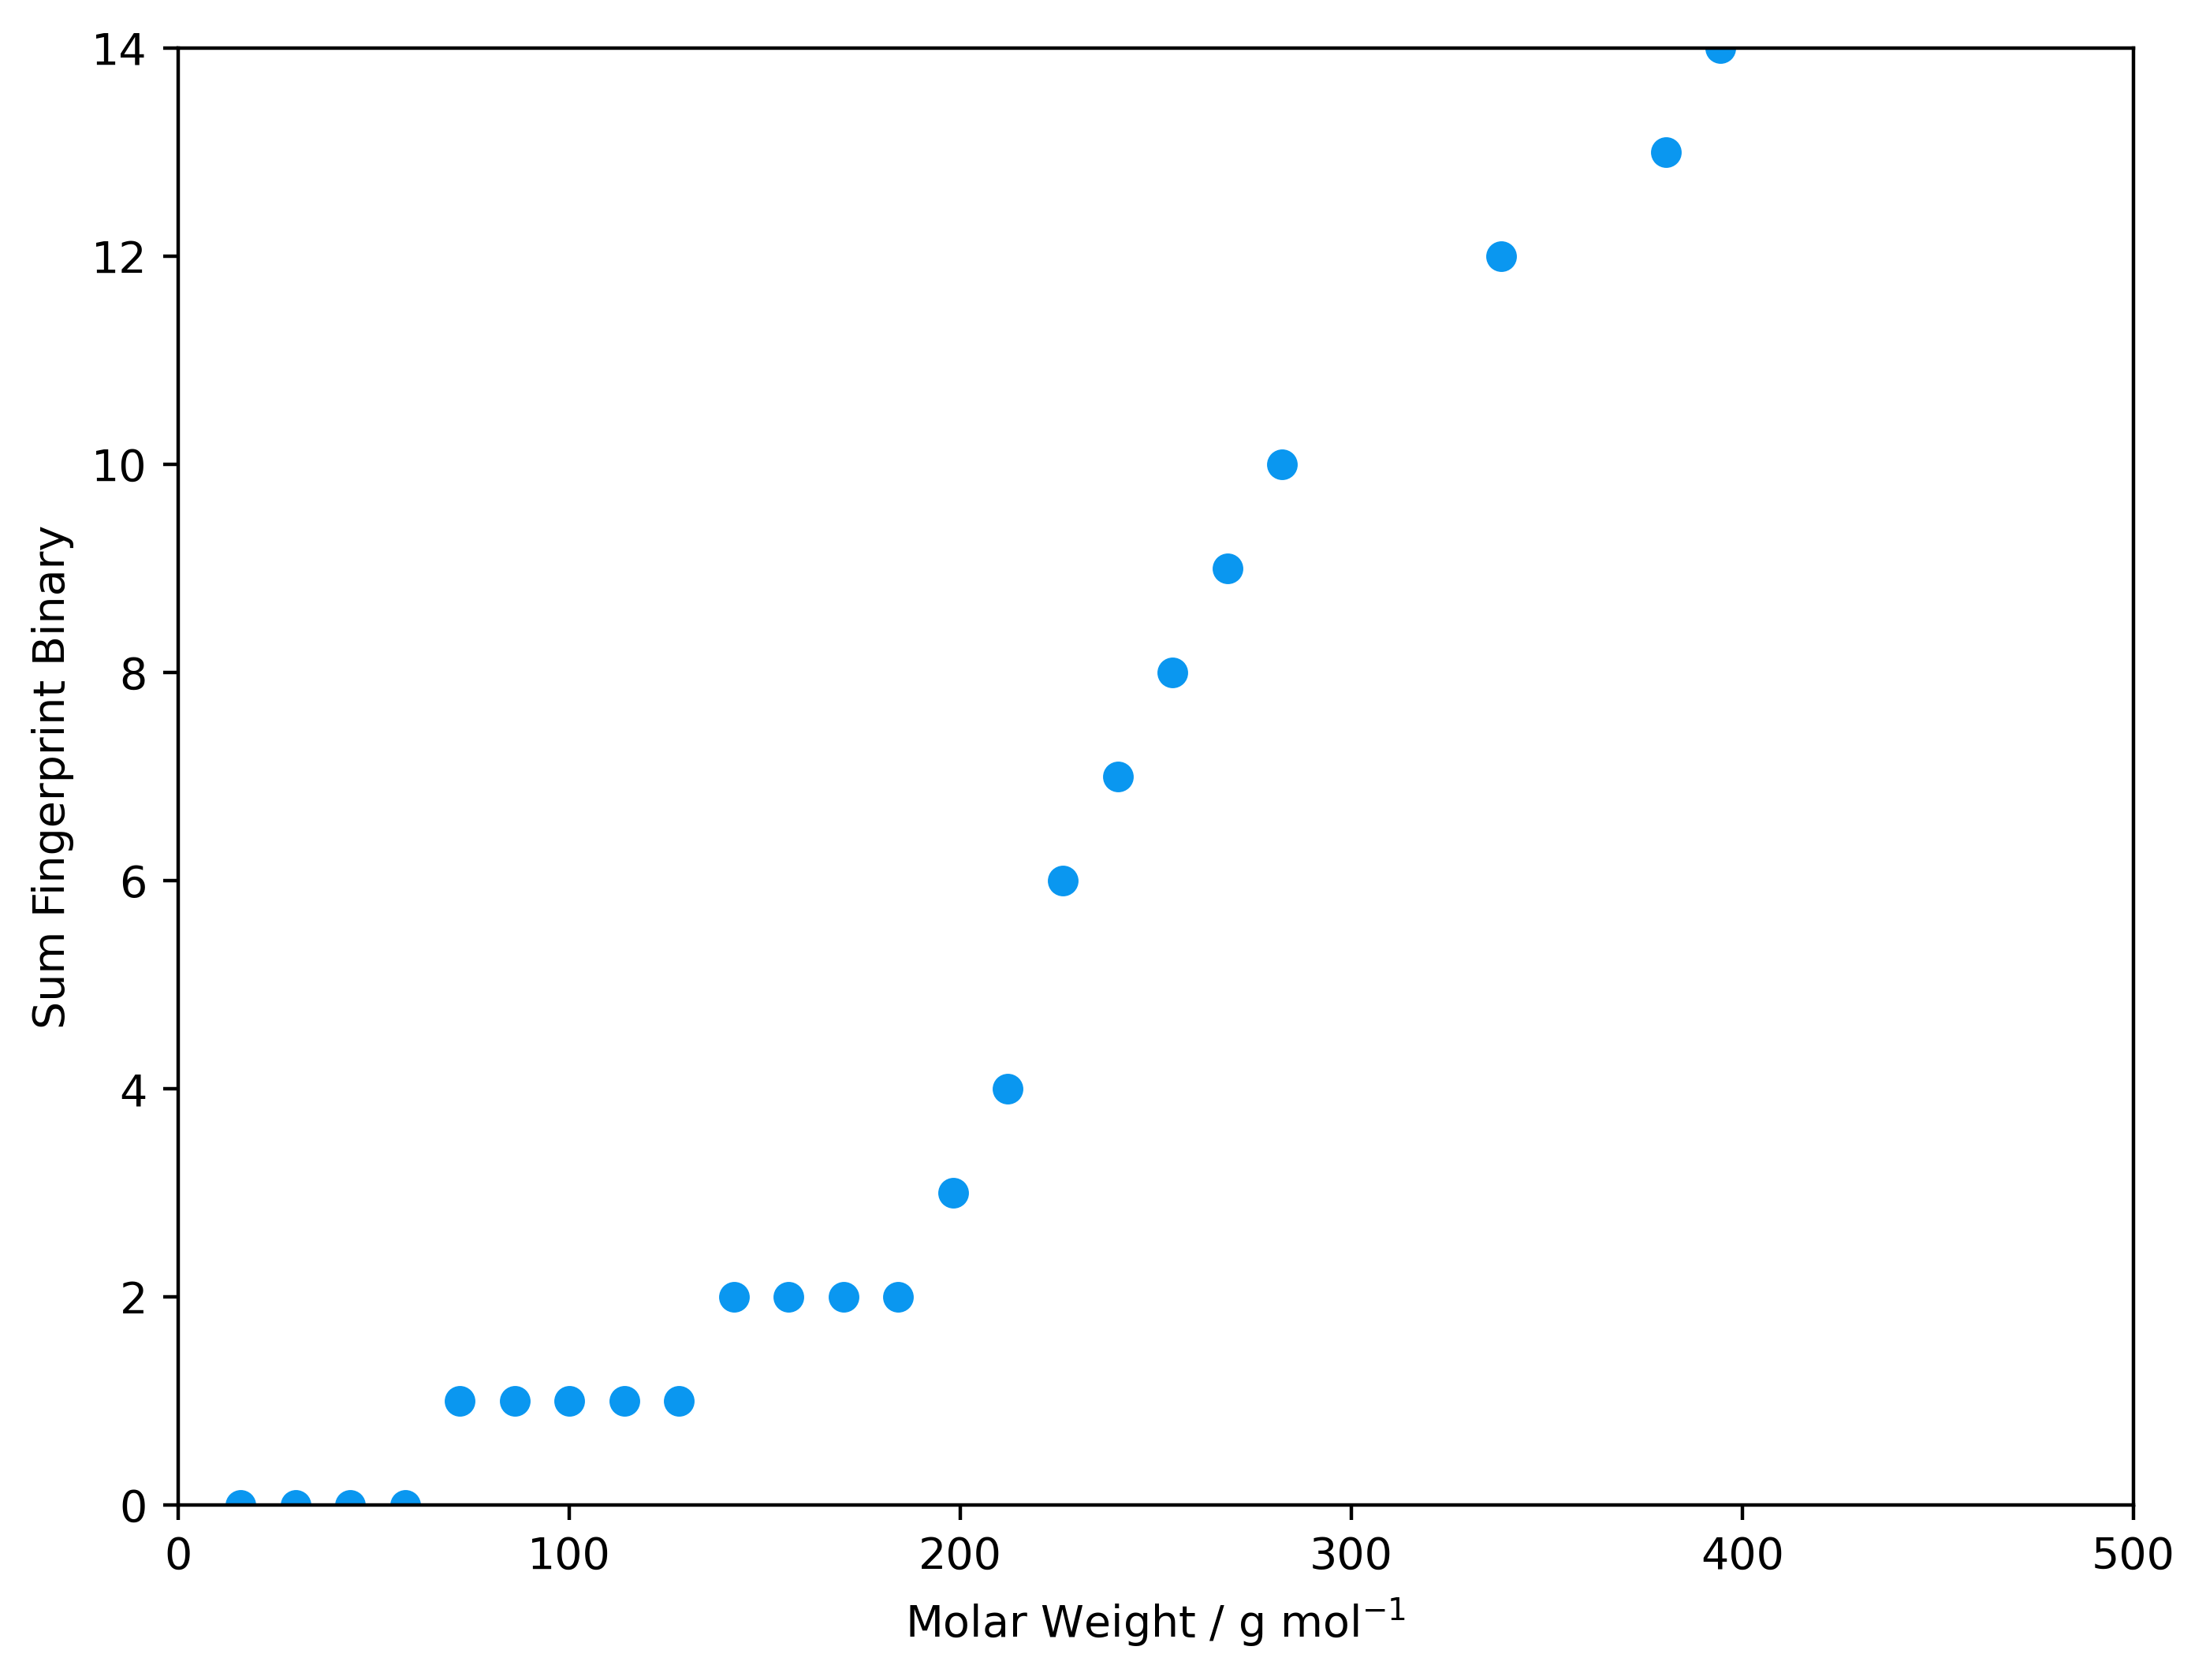

In [172]:
sum_elements = []

for i in fingerprints
    push!(sum_elements, sum(i[1:14]))
end

plt.figure(figsize=(8, 6), dpi=400)
plt.scatter(processed_data_lin_alkanes.Mw, sum_elements,color="#0a97f0")
plt.xlabel("Molar Weight / g mol\$^{-1}\$")
plt.ylabel("Sum Fingerprint Binary")

plt.ylim([0, 14])
plt.xlim([0, 500]);

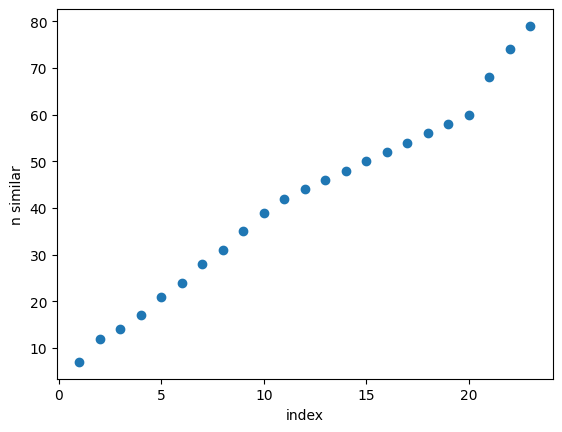

PyObject Text(0.5, 24.0, 'index')

In [199]:
sum_elements = []

x = []
for k = 1:length(fingerprints)
    j = 0

    for i = 1:length(fingerprints[1])
        if fingerprints[end][i] == fingerprints[k][i]
            j += 1
        end
    end

    # @show k, j
    push!(x, (k, j))
end
# println(fingerprints[end])
# println(fingerprints[end-5])

# println(length(fingerprints[1]))
plt.scatter(first.(x), last.(x))
plt.ylabel("n similar")
plt.xlabel("index")